In [1]:
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '/home/amaliak/pyTOUGH/PyTOUGH-master')

In [2]:
## PyTOUGH specific modules
from mulgrids import *
from t2thermo import *
from t2data import *
from t2incons import *
from os import system

In [3]:
def clear_FOFT():
    """To delete previous FOFT files in the directory.
You can delete SAVE, INCON, ... files the same way if you need to do it before running"""
    for file in os.listdir("."):
        if file.startswith("FOFT"):
            try:
                os.remove(file)
            except Exception.e:  # was a comma, changed to a period
                print(e)         # was print e, changed to print(e)
                
def forward_run():
    """ running the tough2 model"""
    system("mpiexec tough2-mp-eos1.debug")

def read_FOFT():
    """ Function to read all FOFT files in the directory.
    The function returns a pandas dataframe containing measurements"""
    FOFT_files = [filename for filename in os.listdir('.') if filename.startswith("FOFT")]
    columns_name = ['Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
    rows = [] 
    for filename in FOFT_files:
        with open(filename, 'rb') as f_input:
            count =0
            for row in f_input:
                if count > 1:
                    a= str(row[0:-1])
                    cols = [col for col in a[2:-1].split(' ') if len(col)]
                    if len(cols)==7:
                        cols[1] = cols[1].ljust(2)
                        cols[1] = cols[1].rjust(3) + cols[2].rjust(2)
                        cols.pop(2)
                        cols.pop(0)
                        rows.append(cols)
                    if len(cols)==6:
                        cols[1] = cols[1].rjust(5)
                        cols.pop(0)
                        rows.append(cols)
                count+=1
    frame = pd.DataFrame(rows, columns=columns_name)
    frame[['Time','Gas Pressure','Gas Saturation','Temperature']] = frame[['Time','Gas Pressure','Gas Saturation','Temperature']].apply(pd.to_numeric)
    return frame

def read_FOFT_old():
    """ Function to read all FOFT files in the directory.
    The function returns a pandas dataframe containing measurements"""
    FOFT_files = [filename for filename in os.listdir('.') if filename.startswith("FOFT")]
    columns = ['FOFT','Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
    b=pd.read_csv(FOFT_files[0],names =columns,  sep="\s+", header =None, skiprows=[0,1])
    if len(b.columns) ==6:
        b[1] = b[1].str.rjust(5)
        b = b.drop([0], axis=1)
    elif len(b.columns) ==7:
        b[1] = b[1].str.ljust(2)
        b[2]=b[2].astype(str)
        b[1] = b[1].str.rjust(3) + b[2].str.rjust(2)
        b = b.drop([0,2], axis=1)
    b.columns= ['Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
    for i in range(1, len(FOFT_files)):
        a=pd.read_csv(FOFT_files[i], sep="\s+", header =None, skiprows=[0,1])
        if len(a.columns) ==6:
            a[1] = a[1].str.rjust(5)
            a = a.drop([0], axis=1)
        elif len(a.columns) ==7:
            a[1] = a[1].str.ljust(2)
            a[2] = a[2].astype(str)
            a[1] = a[1].str.rjust(3) + a[2].str.rjust(2)
            a = a.drop([0,2], axis=1)
        a.columns= ['Element','Time', 'Gas Pressure', 'Gas Saturation','Temperature']
        b=pd.concat([b,a], ignore_index=True)

    return b

def set_measurement_blk(dat, x, y, z, nx):
    
    
    dat.history_block = []
    x_obs = np.array(x)
    y_obs = np.array(y)
    z_obs = np.array(z)
    block_list = nx[0]*nx[1]*(z_obs-1)+nx[0]*(y_obs-1)+x_obs
    for blk_number in block_list:
        dat.history_block.append(dat.grid.blocklist[blk_number].name)


def heat_generator(dat, geo, center, L, qmax, L_scale, method = 'Square'):
    
    
    cols =[]
    if method =='Square':
        for col in geo.columnlist:
            if center[0] - L/2 <= col.centre[0] <= center[0] + L/2:
                if center[1] - L/2<= col.centre[1]<= center[1] + L/2:
                    cols.append(col)
        dxs=np.array([col.centre[0]-center[0] for col in cols])/L_scale
        dys=np.array([col.centre[1]-center[1] for col in cols])/L_scale
        print(dxs)
        print(dys)
        corlength = 0.5
        qcol=qmax*np.exp(-0.5*((dxs*dxs+dys*dys)/(corlength*corlength)))
        print(qcol)
        
        #layer=geo.layerlist[-1] Changing to add the heat in a non-boundary layer
        layer=geo.layerlist[-5]
        # Page 87 from pyTOUGH #####################################
        # adding the generator to the problem
        dat.clear_generators()
        
        dat.add_generator(t2generator(name=' in1', block=' d125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in2', block=' e125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in3', block=' f125', type='COM1', gx=.6, ex=3.E+5))
        dat.add_generator(t2generator(name=' in4', block=' g125', type='COM1', gx=.6, ex=3.E+5))
        
        dat.add_generator(t2generator(name=' ex1', block=' d145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex2', block=' e145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex3', block=' f145', type='COM1', gx=-.6))
        dat.add_generator(t2generator(name=' ex4', block=' g145', type='COM1', gx=-.6))
        
        print('Generators added')
        
        #for col,q in zip(cols,qcol):
        #    blkname=geo.block_name(layer.name,col.name)
        #    genname=' q'+col.name
        #    dat.add_generator(t2generator(name=genname, block=blkname, type='HEAT', gx=q*col.area))
        dat.short_output={}
    else:
        raise NotImplementedError

def construct_grid(dx_grid, nx):
    """Constructing a TOUGH2 input geometry file for a 3D rectangular
    model with the domain size of 300*300*20 m^3 and grid size 10*10*2 m^3."""

    # Here we set up a rectangular grid. For other option, refer to pytough examples and tutorials
    dx = [dx_grid[0]]*nx[0]
    dy = [dx_grid[1]]*nx[1]
    dz = [dx_grid[2]]*nx[2]
    # use convention =2 for naming convention. Otherwise it will generate an error when you want to write INFILE
    # for atmos_type, refer to page 124 pyTOUGH tutorial
    geo = mulgrid().rectangular(dx, dy, dz, atmos_type = 0, convention=2) 
    geo.write('geom.dat')      # write the geometry file

    return geo


#def set_rocktype(dat, z_bottom, z_middle, z_top):
    

def read_SAVE():
    data_SAVE= pd.read_csv('SAVE',sep="\s+", header =None, skiprows=[0], error_bad_lines = False)
    data_SAVE = data_SAVE.drop([0,1, len(data_SAVE)-1])
    blk_1 = []
    blk_2 = []
    blk_3 = []
    for i in range(2,len(data_SAVE)+2):
        if i%2 ==0:
            if math.isnan(data_SAVE[2][i]):
                blk_1.append(data_SAVE[1][i])
            else:
                blk_1.append(data_SAVE[2][i])
        else:
            blk_2.append(float(data_SAVE[0][i]))
            blk_3.append(float(data_SAVE[1][i]))
    data_save = {'Saturation': blk_1,
                 'Pressure': blk_2,
                 'Temperature': blk_3}
    
    df = pd.DataFrame.from_dict(data_save)
    
    return df

def plot_FoFT(data_FOFT, Elem, variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400]):
    ###NOTE THAT PLOTFOFT WILL NOT PLOT ANY OF THE LOCATIONS THAT HAVE A BLANK IN THEIR NAME
    x = np.array(data_FOFT[data_FOFT['Element']==Elem]['Time'])
    plt.plot(x,data_FOFT[data_FOFT['Element']==Elem][variable])
    #plt.axis([0, x[-1], ylim[0], ylim[1]])
    plt.axis([xlim[0], xlim[1], ylim[0], ylim[1]])
    #plt.yticks([])
    plt.show()
    
def plot_SAVE(df, nx, y=0, col = 'Temperature', clim = [0, 100]):
    # old code
    #data_save=np.array(df['Col_1'])
    #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
    #plt.imshow(a[:,:,5].T)
    #plt.colorbar()
    
    #df: output of read_SAVE() function
    # nx: number of grids in the domain in each direction
    # col: can be 'Temperature', 'Pressure', or 'Saturation'
    # clim: determines the range for colorbar
    
    #data_save=np.array(df[col])
    #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
    #plt.imshow(a[:,y,:].T)
    #plt.colorbar()
    #plt.clim(clim[0],clim[1])
    #plt.title(col)
    
    elevation_save = np.zeros((3000,1))
    for idblock in range(1,3001):
        elevation_save[idblock-1] = dat.grid.blocklist[idblock].centre[2]
        
    z = np.reshape(elevation_save,(nx[2],nx[1],nx[0]))
    
    data_save=np.array(df[col])
    
    if col == 'Pressure':
        # Gas pressure converted to m H2O + elevation = hydraulic head in water
        a = np.reshape(data_save*0.00010197,(nx[2],nx[1],nx[0])).T + z.T
        #a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T 
        plt.imshow(a[:,y,:].T)
        #plt.colorbar()
        plt.clim(clim[0],clim[1])
        plt.title('Hydraulic head (m)')
    else:
        a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
        plt.imshow(a[:,y,:].T)
        #plt.colorbar()
        plt.clim(clim[0],clim[1])
        plt.title(col)
        
        
        
def modify_infile():
    f = open("INFILE", "r")
    contents = f.readlines()
    f.close()
    contents.insert(5, 'SEED\n')
    f = open("INFILE", "w")
    contents = "".join(contents)
    f.write(contents)
    f.close()
    
    return

In [4]:

from IPython.core.debugger import Tracer; debug_here = Tracer()

def DistanceVector(x, y, theta):
    dim = x.shape[1]
    DM = np.zeros(x.shape[0])

    if dim == 1:
        DM = (x[:] - y) ** 2. / theta ** 2.
    else:
        for i in np.arange(dim):
            DM += (x[:, i] - y[i]) ** 2. / theta[i] ** 2.

    DM = np.sqrt(DM)
    return DM


def CreateRow(xmin, xmax, N, kernel, theta):
    """
    Create row column of covariance matrix
    """
    dim = N.size

    if dim == 1:
        x = np.linspace(xmin[0], xmax[0], N[0])
        x = x.reshape(-1,1) # make it 2D for consistency
        R = DistanceVector(x, x[0], theta)
    elif dim == 2:
        x1 = np.linspace(xmin[0], xmax[0], N[0])
        x2 = np.linspace(xmin[1], xmax[1], N[1])

        xx, yy = np.meshgrid(x1, x2, indexing='ij')

        x = np.vstack((np.ravel(xx, order='F'), np.ravel(yy, order='F'))).transpose()
        R = DistanceVector(x, x[0, :].transpose(), theta)

    elif dim == 3:
        x1 = np.linspace(xmin[0], xmax[0], N[0])
        x2 = np.linspace(xmin[1], xmax[1], N[1])
        x3 = np.linspace(xmin[2], xmax[2], N[2])

        #xx, yy, zz = np.meshgrid(x1, x2, x3, indexing='ij')
        xx, yy, zz = np.meshgrid(x1, x2, x3, indexing='ij')

        x = np.vstack((np.ravel(xx, order='F'), np.ravel(yy, order='F'), np.ravel(zz, order='F'))).transpose()
        R = DistanceVector(x, x[0, :].transpose(), theta)

    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    row = kernel(R)

    return row, x


def ToeplitzProduct(x, row, N):
    ''' Toeplitz matrix times x
    :param x: x for Qx
    :param row: from CreateRow
    :param N: size in each dimension ex) N = [2,3,4]
    :return: Qx
    '''
    dim = N.size

    if dim == 1:
        circ = np.concatenate((row, row[-2:0:-1])).reshape(-1)
        padded = np.concatenate((x, np.zeros(N[0] - 2)))
        result = np.fft.ifft(np.fft.fft(circ) * np.fft.fft(padded))
        result = np.real(result[0:N[0]])

    elif dim == 2:
        circ = np.reshape(row, (N[0], N[1]), order='F')
        circ = np.concatenate((circ, circ[:, -2:0:-1]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :]), axis=0)

        n = np.shape(circ)
        padded = np.reshape(x, (N[0], N[1]), order='F')

        result = np.fft.ifft2(np.fft.fft2(circ) * np.fft.fft2(padded, n))
        result = np.real(result[0:N[0], 0:N[1]])
        result = np.reshape(result, -1, order='F')

    elif dim == 3:
        circ = np.reshape(row, (N[0], N[1], N[2]), order='F')
        circ = np.concatenate((circ, circ[:, :, -2:0:-1]), axis=2)
        circ = np.concatenate((circ, circ[:, -2:0:-1, :]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :, :]), axis=0)

        n = np.shape(circ)
        padded = np.reshape(x, N, order='F')

        result = np.fft.ifftn(np.fft.fftn(circ) * np.fft.fftn(padded, n))
        result = np.real(result[0:N[0], 0:N[1], 0:N[2]])
        result = np.reshape(result, -1, order='F')
    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    return result


def Realizations(row, N):
    dim = N.size
    if dim == 1:
        circ = np.concatenate((row, row[-2:0:-1]))
        n = circ.shape

        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)
        res = np.fft.ifft(np.sqrt(np.fft.fft(circ)) * eps) * np.sqrt(n)

        r1 = np.real(res[0:N[0]])
        r2 = np.imag(res[0:N[0]])

    elif dim == 2:
        circ = np.reshape(row, (N[0], N[1]), order='F')
        circ = np.concatenate((circ, circ[:, -2:0:-1]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :]), axis=0)

        n = np.shape(circ)
        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)

        res = np.fft.ifft2(np.sqrt(np.fft.fft2(circ)) * eps) * np.sqrt(n[0] * n[1])
        res = res[0:N[0], 0:N[1]]
        res = np.reshape(res, -1, order='F')

        r1 = np.real(res)
        r2 = np.imag(res)

    elif dim == 3:
        circ = np.reshape(row, (N[0], N[1], N[2]), order='F')
        circ = np.concatenate((circ, circ[:, :, -2:0:-1]), axis=2)
        circ = np.concatenate((circ, circ[:, -2:0:-1, :]), axis=1)
        circ = np.concatenate((circ, circ[-2:0:-1, :, :]), axis=0)

        n = np.shape(circ)
        eps = np.random.normal(0, 1, n) + 1j * np.random.normal(0, 1, n)

        res = np.fft.ifftn(np.sqrt(np.fft.fftn(circ)) * eps) * np.sqrt(n[0] * n[1] * n[2])
        res = res[0:N[0], 0:N[1], 0:N[2]]
        res = np.reshape(res, -1, order='F')

        r1 = np.real(res)
        r2 = np.imag(res)
    else:
        raise ValueError("Support 1,2 and 3 dimensions")

    return r1, r2, eps


/home/amaliak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  


In [5]:
# Create TOUGH2 input data file:
dat = t2data()
dat.title = '3D synthetic Ex1'

dx = [10., 10., 2.]   # grid size
nx = [30, 10, 10]     # number of grids in each dimension. Don't use large grid because of pytough naming convention
geo = construct_grid(dx, nx)
dat.grid = t2grid().fromgeo(geo)


In [6]:
alpha = 100
def kernel(R):
        return alpha * np.exp(-R)
dim = 3
np.random.seed(101)
N = np.array(nx)
dX = np.array(dx)
x_max = N*dX
x_min = np.zeros(dim)
theta = np.array([300,300,10])
row, pts = CreateRow(x_min, x_max, N, kernel,theta)
r1, r2, ep = Realizations(row, N)


43.6096878575
0.113451108111


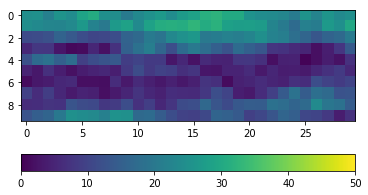

In [7]:
realization = np.sqrt(r1**2+r2**2)
realization1 = realization.reshape(N[2],N[1],N[0])
plt.imshow(realization1[:,4,:] )
plt.colorbar(orientation='horizontal')
plt.clim(0,50)
print(np.max(realization))
print(np.min(realization))

In [8]:
# simulation parameters:
# Table 4.9 page 78 pytough tutorial and Appendix E of TOUGH2 tutorial
# data.parameter is a dictionary
# each parameter can be called as dat.parameter['parameter name']
dat.parameter.update(
    {'max_timesteps': 9000,                 # maximum number of time steps
     'tstop': 0.32342126E+08,                   # stop time
     'const_timestep': 6,                   # time step length
     'max_timestep':86400,                   # maximum time step size
     'absolute_error': 1,                   # absolute convergence tolerance
     'relative_error': 5.e-6,               # relative convergence tolerance
     'print_interval': 9000,                # time step interval for printing
     'timestep_reduction': 3.,              # time step reduction factor
     'gravity': 9.81,                       # gravitational acceleration
     'default_incons': [100.e4, 10]})      # default initial conditions
    # Pressure in Pa, 100 m water = 10.e5 Pa water, 10 is the temperature in Celcius
dat.start = True

In [9]:

# Table 4.9 page 78 pytough tutorial and Appendix E of TOUGH2 tutorial
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.396.8810&rep=rep1&type=pdf
# Set MOPs: PARAM option in INFILE
dat.parameter['option'][1] = 1
dat.parameter['option'][5] = 3
dat.parameter['option'][7] = 1
dat.parameter['option'][11] = 2
dat.parameter['option'][12] = 2
dat.parameter['option'][15] = 1
dat.parameter['option'][16] = 4
dat.parameter['option'][20] = 0
dat.parameter['option'][21] = 1


In [10]:
# Set relative permeability (Corey) and capillarity functions:
# Table 4.10, page 79 PYTOUGH
dat.relative_permeability = {'type': 7, 'parameters': [0.95, 0.5, 1., 0.25, 0.]}
dat.capillarity = {'type': 7, 'parameters': [0.8, 0.32, 1.e-4, 1.e7, 0.999]}


In [11]:
# rocktype object, Table 3.3, page 67 PyTOUGH
r1 = rocktype('dfalt', permeability = [0.e-13]*3,density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
r2 = rocktype('HOMO1', permeability = [9.e-13, 3.e-14, 3.e-14],density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
#r4 = rocktype('HOMO2', permeability = [9.e-15, 3.e-15, 3.e-15],density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 920,)
r3 = rocktype('OUTB1', permeability = [1.e-13]*3,density = 2600, porosity = 0.25,conductivity =2.51 , specific_heat = 20000,)
dat.grid.add_rocktype(r2)
dat.grid.add_rocktype(r3)
#dat.grid.add_rocktype(r4)

#dat.grid.add_rocktype(r3)
dat.multi.update({'num_components': 1, 'num_equations':2, 'num_phases':2, 'num_secondary_parameters':6})


In [12]:
print(dat.multi)
dat.grid.rocktype
dat.grid.rocktype
dat.grid.check
r3.permeability

{'num_components': 1, 'num_equations': 2, 'num_phases': 2, 'num_secondary_parameters': 6}


array([  1.00000000e-13,   1.00000000e-13,   1.00000000e-13])

In [13]:
# SOLVR Table 4.11 page 79 PyTough
dat.solver.update({'type': 5, 'z_precond':1,'o_precond': 0, 'relative_max_iterations':.8,'closure':1.e-7 })


In [14]:
#print(dat.output_times)
#type(dat.output_times['time'])

In [15]:
# TIMES table 4.8
dat.output_times.update({'num_times_specified':2, 'time': [0.8640E+04, 0.32342126E+08]})


In [16]:
print(dat.output_times['time'][1]/86400)
# prints output times in days

374.33016203703704


In [17]:
dat.grid.blocklist[1000].centre

array([ 95.,  35.,  -7.])

In [18]:
# rocktypes:
# Setting rocktype based on the block's 'z' coordinate
z_bottom = -17
z_top = -2

# assign all non boundary elements to r2
for blk in dat.grid.blocklist[1:]: 
    if z_bottom < blk.centre[2] < z_top:
        blk.rocktype=r2
    else: blk.rocktype=r3
   
lense = 0

if lense==1:
    # within homeogeneous domain, assign a lense that is in the way of the injection
    lense_bottom_z = -14
    lense_top_z = -8
    lense_start_x = 65
    lense_end_x = 115
    for blk in dat.grid.blocklist[1:]:
        if lense_bottom_z < blk.centre[2] < lense_top_z:
            if lense_start_x < blk.centre[0] < lense_end_x:
                blk.rocktype=r4
    
dat.grid.clean_rocktypes()

In [19]:
for blk, pmx in zip(dat.grid.blocklist[1:], realization):
    #blk.pmx = 1
    blk.pmx = pmx
    #print(pmxb)

In [20]:
print(dat.grid)
print(r2)

3 rock types; 3001 blocks; 8600 connections
HOMO1


In [21]:
# setting the blocks for FOFT
# this section needs to be modified. FOFT blocks can be given by the coordinate of the block, or by the block name
# currently, it accepts the cell number in each direction
# for example the first cell here is located in grid (2,2) in 5th layer
x_obs = [7,10,14]#[2,4,14,16]
y_obs = [5,5,5]#[2,4,14,16]
z_obs = [6,6,6]

# from function definition above 
# set_measurement_blk(dat, x, y, z, nx):
set_measurement_blk(dat, x_obs, y_obs, z_obs, nx)

In [22]:
print(dat.history_block)
print(nx)


[' f127', ' f130', ' f134']
[30, 10, 10]


In [23]:
# just checking the name of measurement blocks
# f124 coordinates are 35,45,10  and it is the 2nd observationn point at 4,4,5 element :1

dat.history_block

[' f127', ' f130', ' f134']

In [24]:
# adding generators to the model

center = [150, 150] # [x,y] position of the center
L = 40     # length of one side of square
qmax = 15000
L_scale = 300


In [25]:
heat_generator(dat, geo, center, L, qmax, L_scale, method = 'Square')
# just checking the generator blocks


[]
[]
[]
Generators added


In [26]:
# Write data file

dat.write('INFILE')
modify_infile()


In [27]:
clear_FOFT()

In [28]:
# running tough2_mp
forward_run()

In [29]:
# measured_data = read_FOFT()

In [30]:
measured_data = read_FOFT()
#print(measured_data)

In [31]:
data_save = read_SAVE()

b'Skipping line 6005: expected 3 fields, saw 5\nSkipping line 6006: expected 3 fields, saw 10\n'


In [32]:
data_save['Temperature']


0       10.007679
1       10.016191
2       10.022759
3       10.031027
4       10.038485
5       10.045691
6       10.045596
7       10.040850
8       10.034503
9       10.028558
10      10.022841
11      10.018004
12      10.013342
13      10.009689
14      10.007086
15      10.005137
16      10.003635
17      10.002603
18      10.001972
19      10.001603
20      10.001349
21      10.001227
22      10.001188
23      10.001117
24      10.001071
25      10.001082
26      10.000962
27      10.000966
28      10.000956
29      10.000995
          ...    
2970    10.000714
2971    10.000732
2972    10.000841
2973    10.000907
2974    10.000916
2975    10.000875
2976    10.000817
2977    10.000761
2978    10.000720
2979    10.000705
2980    10.000674
2981    10.000637
2982    10.000608
2983    10.000577
2984    10.000557
2985    10.000591
2986    10.000623
2987    10.000604
2988    10.000558
2989    10.000540
2990    10.000553
2991    10.000454
2992    10.000348
2993    10.000329
2994    10

 f134


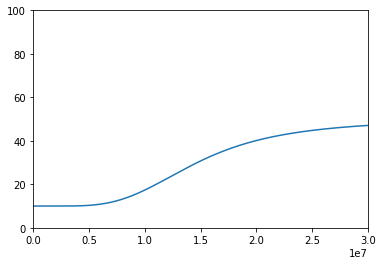

In [33]:
print(dat.history_block[2])
plot_FoFT(measured_data, dat.history_block[2], variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400*347]) # ylim sets the range fo

 f127


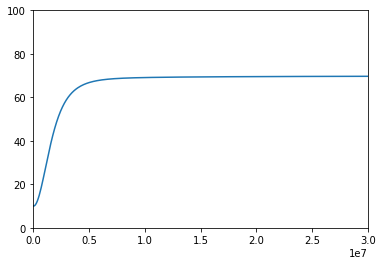

In [34]:
print(dat.history_block[0])
plot_FoFT(measured_data, dat.history_block[0], variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400*347]) # ylim sets the range fo


 f130


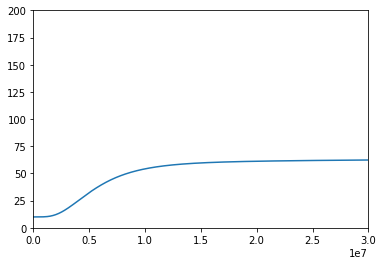

In [35]:
print(dat.history_block[1])
plot_FoFT(measured_data, dat.history_block[1], variable = 'Temperature', ylim = [0, 200], xlim = [0, 86400*347]) # ylim sets the range fo


In [36]:
## Here you are printing the same 
##Elem = dat.history_block[1]
##print(dat.history_block[:])
#for Elm in dat.history_block:
#    print(Elm)
#    plot_FoFT(measured_data, Elm, variable = 'Temperature', ylim = [0, 100], xlim = [0, 86400]) # ylim sets the range for y axis

In [37]:
data_save_T=np.array(data_save['Temperature']) # you should give the whole data frame as input to plot_SAVE function
data_save_T                                    # so you don't need to read the Temperature column here. I renamed the variable here

array([ 10.00767921,  10.01619073,  10.02275905, ...,  10.00029266,
        10.0003669 ,  10.0003476 ])

Text(0,0.5,'z(m)')

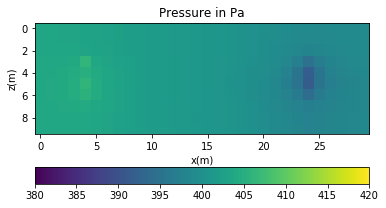

In [42]:
#data_save, 'y' variable here sets which y cross=section you want to plot
plot_SAVE(data_save, nx, y=4, col = 'Pressure', clim = [380, 420])
#data_save=np.array(data_save['Temperature'])
#a = np.reshape(data_save,(nx[2],nx[1],nx[0])).T
#plt.imshow(a[:,:,5].T)
plt.colorbar(orientation='horizontal')
plt.title('Pressure in Pa')
plt.xlabel('x(m)')
plt.ylabel('z(m)')


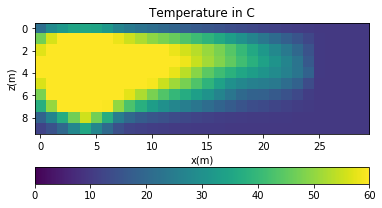

In [43]:
plot_SAVE(data_save, nx, y=4, col = 'Temperature', clim = [0, 60])
plt.title('Temperature in C')
plt.xlabel('x(m)')
plt.ylabel('z(m)')
plt.colorbar(orientation='horizontal')